In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from minisom import MiniSom


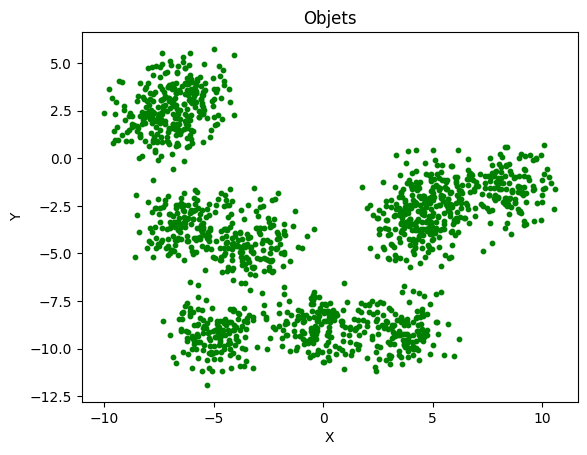

In [44]:
k = 10
n_samples = 1500  # Change number of data points
X, _ = make_blobs(n_samples=n_samples, centers=k, n_features=2, shuffle=True, random_state=41)

# Créer un DataFrame à partir de X
data = pd.DataFrame(X, columns=['x', 'y'])

# Afficher les données avec Matplotlib
plt.scatter(X[:, 0], X[:, 1], c='green', s=10)
plt.title('Objets')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [41]:
def initialiser_centroids(k, data):
    n_dims = data.shape[1]
    centroid_min, centroid_max = np.min(data, axis=0), np.max(data, axis=0)
    centroids = np.random.uniform(centroid_min, centroid_max, size=(k, n_dims))
    centroids = pd.DataFrame(centroids, columns=data.columns)
    return centroids

def calculer_distance(x1, x2):
    distance = np.sum(np.square(x1 - x2))
    return distance

def assigner_centroid(data, centroids):  
    n_objets = data.shape[0]
    centroid_assign = []
    centroid_distances = []
    k = centroids.shape[0]
    centroids_arr = centroids.iloc[:, :2].to_numpy()

    for objet in range(n_objets):
        distances = np.sum(np.square(centroids_arr - data.iloc[objet, :2].to_numpy()), axis=1)
        centroid_plus_proche = np.argmin(distances)
        centroid_distance = np.min(distances)
        centroid_assign.append(centroid_plus_proche)
        centroid_distances.append(centroid_distance)

    return (centroid_assign, centroid_distances)

def kmeans(data, k):
    centroids = initialiser_centroids(k, data)
    distance = []
    compr = True
    i = 0
    while compr:
        data['centroid'], iter_distance = assigner_centroid(data, centroids)
        distance.append(sum(iter_distance))
        centroids = data.groupby('centroid').agg('mean').reset_index(drop=True)
        if len(distance) < 2:
            compr = True   
        else:
            if round(distance[i], 3) != round(distance[i-1], 3):
                compr = True
            else:
                compr = False
        i += 1
    data['centroid'], iter_distance = assigner_centroid(data, centroids)
    centroids = data.groupby('centroid').agg('mean').reset_index(drop=True)
    return (data['centroid'], iter_distance, centroids)

def kmeans_silhouette(data):
    silhouette_scores = []
    max_k = min(len(data), 10)
    for k in range(2, max_k + 1):
        data['centroid'], iter_distance, centroids = kmeans(data, k)
        score = silhouette_score(data[['x', 'y']], data['centroid'])
        silhouette_scores.append(score)
    
    plt.plot(range(2, max_k + 1), silhouette_scores)
    plt.title('Silhouette Score Curve')
    plt.xlabel('Nombre de clusters')
    plt.ylabel('Silhouette Score')
    plt.show()
    
    best_k = np.argmax(silhouette_scores) + 2
    print("Meilleur K :", best_k)
    
    centroids = initialiser_centroids(best_k, data)
    data['centroid'], iter_distance = assigner_centroid(data, centroids)
    centroids = data.groupby('centroid').agg('mean').reset_index(drop=True)
    
    return (data['centroid'], iter_distance, centroids)

def som_cluster(data, k):
    data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
    som_grid = MiniSom(k, k, data.shape[1], sigma=1.0, learning_rate=0.5)
    som_grid.random_weights_init(data)
    num_iterations = 100
    som_grid.train_random(data.to_numpy(), num_iterations*10)
    clusters = []
    for i in range(data.shape[0]):
        x = data.iloc[i]
        cluster = som_grid.winner(x)
        clusters.append(cluster)
    return clusters

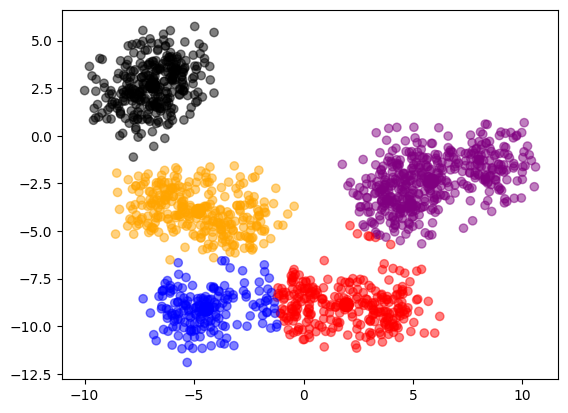

In [50]:
# Exécuter K-means pour k = 5
data_centroids, _, centroids = kmeans(data, 5)
colors = ['red', 'blue', 'black', 'purple', 'orange', 'gray', 'green', 'yellow', 'cyan', 'magenta']
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], marker='o', c=data['centroid'].apply(lambda x: colors[x % len(colors)]), alpha=0.5)
plt.scatter(centroids.iloc[:, 0], centroids.iloc[:, 1], marker='o', s=100, c=[colors[i % len(colors)] for i in centroids.index])
plt.show()

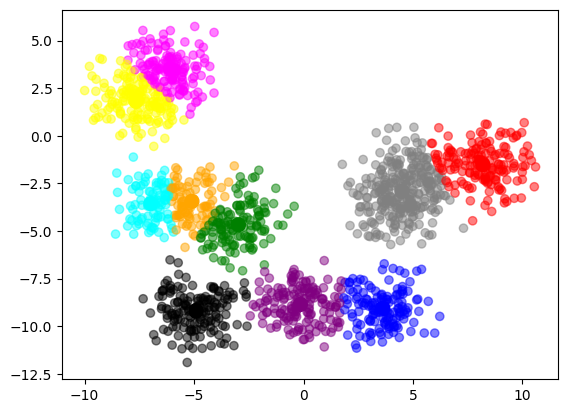

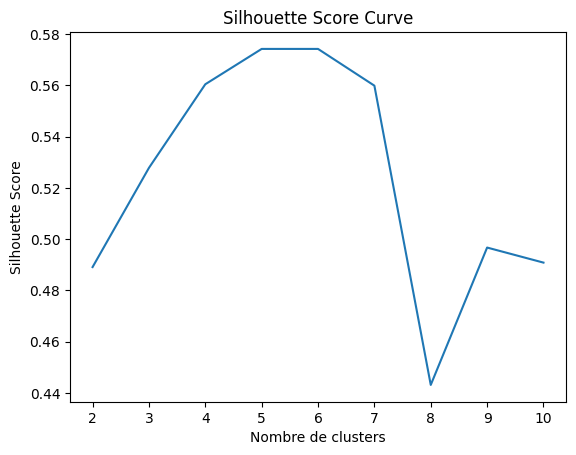

Meilleur K : 5


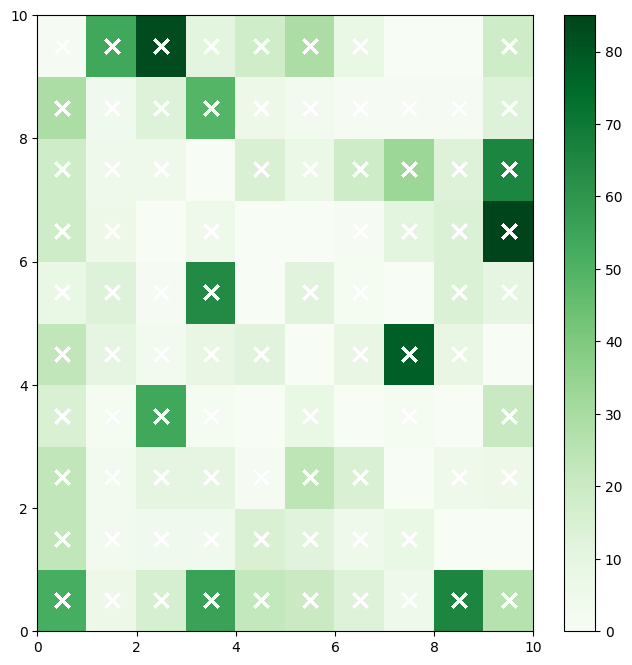

In [47]:
# Exécuter K-means
data_centroids, _, centroids = kmeans(data, k)
colors = ['red', 'blue', 'black', 'purple', 'orange', 'gray', 'green', 'yellow', 'cyan', 'magenta']
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], marker='o', c=data['centroid'].apply(lambda x: colors[x % len(colors)]), alpha=0.5)
plt.scatter(centroids.iloc[:, 0], centroids.iloc[:, 1], marker='o', s=100, c=[colors[i % len(colors)] for i in centroids.index])
plt.show()

# Exécuter K-means avec Silhouette Score
kmeans_silhouette(data)

# Définir les dimensions de la carte SOM
som_width = 10
som_height = 10
input_len = 2

# Initialiser la carte SOM avec les dimensions précédentes
som = MiniSom(som_width, som_height, input_len, sigma=1.0, learning_rate=0.5)
som.random_weights_init(X)

# Entraîner la carte SOM sur les données
som.train_random(data=X, num_iteration=100)

# Trouver les gagnants pour chaque échantillon de données
winners = np.zeros((som_width, som_height))
for i in range(len(X)):
    x = X[i]
    winner = som.winner(x)
    winners[winner] += 1

# Visualiser la carte SOM et les données d'entrée
plt.figure(figsize=(8, 8))
plt.pcolor(winners.T, cmap='Greens')
plt.colorbar()

# Ajouter les marqueurs de données sur la carte SOM
for i, x in enumerate(X):
    winner = som.winner(x)
    plt.plot(winner[0] + 0.5, winner[1] + 0.5, 'x', markerfacecolor='None', markeredgecolor='white', markersize=10, markeredgewidth=2)

plt.show()